## Классификация изображений 
### Тестовое задание

В распоряжении две папки, в одной находятся изоброжения Георгия, в другой не-Георгий. Задача обучить модель классификации Георгиев от не-Георгиев. В качестве метрики модели использована accuracy.

In [18]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50

from sklearn.model_selection import GridSearchCV, train_test_split

from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib
import requests

In [2]:
columns_name = ['file_name']

In [3]:
georges_data = pd.read_csv('/Users/albertsafin/Desktop/data/georges.csv',names=columns_name)
non_georges_data = pd.read_csv('/Users/albertsafin/Desktop/data/non_georges.csv',names=columns_name)

In [4]:
non_georges_data.info()
georges_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3366 entries, 0 to 3365
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  3366 non-null   object
dtypes: object(1)
memory usage: 26.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2681 entries, 0 to 2680
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  2681 non-null   object
dtypes: object(1)
memory usage: 21.1+ KB


В папке с изображением Гоергия 2681 файл, а во второй с не-Георгием - 3366 файлов.

In [5]:
georges_data['georg_pict'] = 1
non_georges_data['georg_pict'] = 0

Изображение Георгия на картинке будем считать за 1, в противном случае - 0

In [6]:
data_full = georges_data.append(non_georges_data).sample(frac=1, random_state=12345).reset_index(drop=True).reset_index()

In [7]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6047 entries, 0 to 6046
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6047 non-null   int64 
 1   file_name   6047 non-null   object
 2   georg_pict  6047 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 141.9+ KB


In [8]:
def image_func(row):
    url = row['file_name']
    return str(Image.open(requests.get(url, stream=True).raw))

In [9]:
data_full['image'] = data_full.apply(image_func, axis=1)

Преобразование ссылок на файлы в формат, который можно будет прочесть

In [10]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6047 entries, 0 to 6046
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       6047 non-null   int64 
 1   file_name   6047 non-null   object
 2   georg_pict  6047 non-null   int64 
 3   image       6047 non-null   object
dtypes: int64(2), object(2)
memory usage: 189.1+ KB


In [11]:
def download_func(row):
    url = row['file_name']
    i = str(row['image'])
    urllib.request.urlretrieve(url,'/Users/albertsafin/Desktop/data/gosha/'+ i)

In [12]:
data_full.apply(download_func, axis=1)

0       None
1       None
2       None
3       None
4       None
        ... 
6042    None
6043    None
6044    None
6045    None
6046    None
Length: 6047, dtype: object

Скачал файлы для их дальнейшего использования в библиотеке keras

In [60]:
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe= data_full,
        directory= '/Users/albertsafin/Desktop/data/gosha/',
        x_col='image',
        y_col='georg_pict',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        validate_filenames=False,
        seed=12345)

Found 6047 non-validated image filenames.


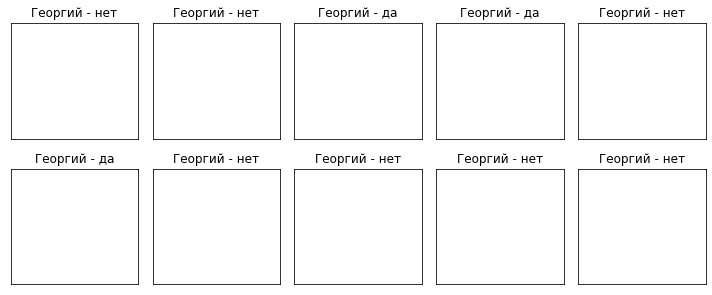

In [63]:
features, target = next(gen_flow)
fig = plt.figure(figsize=(10,10))

for i in range(10,20):
    
    if target[i] == 1: 
        gosha = 'да'
    else: 
        gosha = 'нет'
        
    fig.add_subplot(5, 5, i+1)
    #plt.imshow(features[i])
    plt.title('Георгий - ' + gosha)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Проверка изображений показала, что картинки определены правильно. (Убрал изображения, дабы не нарушать авторские права)

In [19]:
 data_train, data_test = train_test_split(data_full, test_size = 0.25, random_state=12345)

In [68]:
data_train.info()
#data_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4535 entries, 4702 to 4578
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       4535 non-null   int64 
 1   file_name   4535 non-null   object
 2   georg_pict  4535 non-null   int64 
 3   image       4535 non-null   object
dtypes: int64(2), object(2)
memory usage: 177.1+ KB


Разделил данные на обучающую и тестовую выборки.

In [37]:
def load_train(path):
    
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe= data_train,
        directory= path,
        x_col='image',
        y_col='georg_pict',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        validate_filenames=False,
        seed=12345)

    return train_gen_flow

In [34]:
def load_test(path):
    
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)

    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe= data_test,
        directory= path,
        x_col='image',
        y_col='georg_pict',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        validate_filenames=False,
        seed=12345)

    return test_gen_flow

In [73]:
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    opt = Adam(lr=0.0001)
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])

    return model


Воспользовался слоями GlobalAveragePooling2D для усреднения информации по всему изображению, то есть получить пиксель с большим количеством каналов, Dense — полносвязный слой для классификации. Использовал также алгоритм Adam для ускорения обучения.

In [74]:
def train_model(model, train_data, test_data, batch_size=16,
                epochs=10, steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Функции для загрузки данных, а также использование модели ResNet50 для обучения на обучающей выборки. В ходе тестов было выявлено, что 10 эпох будет достаточно для обучения модели.

In [75]:
train = load_train('/Users/albertsafin/Desktop/data/gosha/')

Found 3402 non-validated image filenames.


In [76]:
test = load_test('/Users/albertsafin/Desktop/data/gosha/')

Found 378 non-validated image filenames.


In [77]:
model = create_model((224,224,3))

In [78]:
model_train = train_model(model,train,test)

Epoch 1/10
213/213 - 745s - loss: 0.3238 - accuracy: 0.6975 - val_loss: 0.4101 - val_accuracy: 0.5899
Epoch 2/10
213/213 - 796s - loss: 0.1554 - accuracy: 0.8301 - val_loss: 0.4101 - val_accuracy: 0.5899
Epoch 3/10
213/213 - 780s - loss: 0.0872 - accuracy: 0.9150 - val_loss: 0.2330 - val_accuracy: 0.6402
Epoch 4/10
213/213 - 772s - loss: 0.0547 - accuracy: 0.9497 - val_loss: 0.1654 - val_accuracy: 0.8201
Epoch 5/10
213/213 - 723s - loss: 0.0493 - accuracy: 0.9603 - val_loss: 0.1099 - val_accuracy: 0.8783
Epoch 6/10
213/213 - 702s - loss: 0.0610 - accuracy: 0.9456 - val_loss: 0.1596 - val_accuracy: 0.8122
Epoch 7/10
213/213 - 808s - loss: 0.0944 - accuracy: 0.9053 - val_loss: 0.1710 - val_accuracy: 0.7963
Epoch 8/10
213/213 - 707s - loss: 0.0744 - accuracy: 0.9292 - val_loss: 0.1085 - val_accuracy: 0.8783
Epoch 9/10
213/213 - 718s - loss: 0.0503 - accuracy: 0.9571 - val_loss: 0.0870 - val_accuracy: 0.9048
Epoch 10/10
213/213 - 720s - loss: 0.0366 - accuracy: 0.9706 - val_loss: 0.0923 - 

## ИТОГ

- Проверены изоброжения на адекватность. В папке с Георгием действительно изображен он.
- Проведена предобработка файлов для дальнейшего обучения модели
- Построена модель на основе *ResNet50*, в качестве метрики использовалась - **accuracy**, которая показала на тестовой выборке неплохой результат - **0.90**. Модель сможет определить Георгия от не-Георгия